# Introduction

You all know word clouds:

![](resources/constitution.png)  


They give you a quick overview of the top topics of your blog, book, source code &ndash; or presentation. The latter was the one that got me thinking: How cool would it be if you start your presentation with a word cloud of the main topics of your talk? And: How easy is it to do that completely automated with Python?!

So let's go crazy this time with **word cloud computing** for different data sources like texts, web sites, source code and PowerPoint presentations!

# The Idea
The main idea is to read any text in any format, preprocess it and throw it against a word cloud producing library. For this, we need some main libraries that do all the work for us:

* <tt>[nltk](http://www.nltk.org/)</tt> for some big texts and for cleaning up our input texts
* <tt>[beautifulsoup](https://www.crummy.com/software/BeautifulSoup/)</tt> for getting raw texts from HTML websites
* <tt>[pygments](http://pygments.org/)</tt> for retrieving identifiers from source code
* <tt>[python-pptx](https://python-pptx.readthedocs.io/en/latest/)</tt> for extracting texts from PowerPoint slides
* <tt>[wordcloud](https://github.com/amueller/word_cloud)</tt> for producing, well, a word cloud

So let's get started!

# Basic example
In this section, I demonstrate how easy it is to produce a word cloud from some given text with <tt>wordcloud</tt>. We import the <tt>WordCloud</tt> class and use it directly to generate a word cloud with two words.

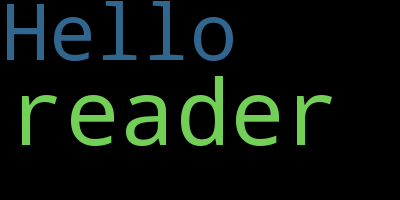

In [1]:
from wordcloud import WordCloud
WordCloud().generate("Hello reader!").to_image()

We see that <tt>wordcloud</tt> just did some text preprocessing (like removing the "!") and rendered the texts.

That's it!

# Advanced example
The example above wasn't very impressive and expressive. So we use <tt>nltk</tt> to retrieve some big texts from a corpus. In the following word cloud, we want to display the main topics of some movie reviews. 

In [2]:
from nltk.corpus import movie_reviews
movie_reviews.words()[:10]

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party']

We also need some basic text preprocessing: removing the language's common words via a stop list for that language. The stop list is just a different kind of corpus &ndash; a list of text tokens.

In [3]:
from nltk.corpus import stopwords
english_stopword_tokens = stopwords.words('english')
english_stopword_tokens[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

Let's do some basic text preprocessing by only keeping alphabetic characters and removing the stop words.

In [4]:
movie_reviews_tokens = [s for s in movie_reviews.words() 
                        if s.isalpha() and 
                        not s in english_stopword_tokens]
movie_reviews_tokens[:5]

['plot', 'two', 'teen', 'couples', 'go']

We join the text array together to get a long string and display it as word cloud.

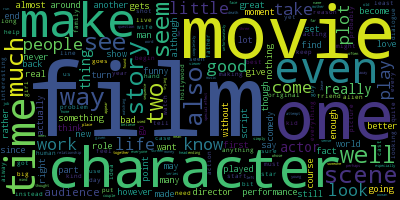

In [5]:
movie_reviews_texts = " ".join(movie_reviews_tokens)
WordCloud().generate(movie_reviews_texts).to_image()

Let's move on to some more interesting visualizations.

# HTML webpage

We can read any website via Python's built-in <tt>request</tt> library. In this example, we read the [aim42](http://aim42.org/) (a guide for software architecture improvement; very valuable and interesting!) directly from the guide's website. We just need to get the response's text, that delivers the website as pure HTML.

In [6]:
import requests
webpage = requests.get("http://aim42.github.io/")
webpage.text[:100]

'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="UTF-8">\n<!--[if IE]><meta http-equiv="X-UA-Co'

We use <tt>beautifulsoup</tt> so get only the text from the HTML.

In [7]:
from bs4 import BeautifulSoup
parsed_content = BeautifulSoup(webpage.text, 'html.parser')
text_content = parsed_content.body.get_text()
text_content[:100]

'\n\n Method Guide \n\nTable of Contents\n\nAbout aim42\n1. Introduction\n\n1.1. Why is software being changed'

Again, we clean up the data by only processing any alphabetic text and keeping all the tokens that aren't in the stop word list.

In [8]:
content_tokens = []
for line in text_content.split("\n"):
    for token in line.split(" "):
        if token.isalpha() and not token in english_stopword_tokens:
            content_tokens.append(token.lower())
content_tokens[0:5]

['method', 'guide', 'table', 'contents', 'about']

And again ,we produce a word cloud. For a nicer styling, we set some arguments in the contructor.

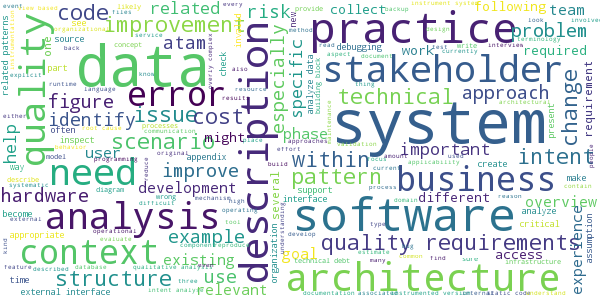

In [9]:
text = " ".join(content_tokens)
WordCloud(max_font_size=40,
          scale=1.5,
          background_color="white").generate(text).to_image()

Here we are! The aim42 guide is (amongst other things) about data, system and architecture :-).

# Source Code identifier

Next, we move over to source code!

It's nice to get a quick overview of what your software is all about. Our study object, in this case, is the [Spring PetClinic](https://github.com/spring-projects/spring-petclinic). For our nice word cloud, we need to read all the source code files, extract the identifiers, handle some programming language specific cases and remove common words via the stop list.

And here comes some magic all in one dirty little code block (I promise to get through it step by step in another blog post/notebook):

* We use <tt>glob</tt> to get a list of source code paths and read the content.
* We use <tt>pygments</tt>'s <tt>JavaLexer</tt> to retrieve just the tokens we want.
* We use some regex voodoo to break Java's CamelCase names into separate words.
* We filter out common Java and English words via a stop list.
* We set a minimal number of characters a word has to consist of.

In [10]:
import glob
from pygments.token import Token
from pygments.lexers.jvm import JavaLexer
import re

LEXER = JavaLexer()

CAMEL_CASE_1_PATTERN = re.compile(r'(.)([A-Z][a-z]+)')
CAMEL_CASE_2_PATTERN = re.compile(r'([a-z0-9])([A-Z])')
WORD_BOUNDARY_PATTERN = re.compile(r'[^a-zA-Z]')

JAVA_STOP_WORDS = set(["byte", "short", "int", "long", 
                       "float", "double", "char", "string", 
                       "object", "java", "get", "set", "is"])

STOP_LIST = JAVA_STOP_WORDS | set(english_stopword_tokens)
MIN_WORD_LENGTH = 3


def break_tokens(tokens):
    tokens = CAMEL_CASE_1_PATTERN.sub(r'\1 \2', tokens)
    tokens = CAMEL_CASE_2_PATTERN.sub(r'\1 \2', tokens)
    tokens = WORD_BOUNDARY_PATTERN.sub(' ', tokens)
    return tokens.split(' ')


def filter_token(tokens_of_name):
    filtered_tokens = []
    for token in tokens_of_name:
        if len(token) >= MIN_WORD_LENGTH and token.lower() not in STOP_LIST:
            filtered_tokens.append(token.lower())
    return filtered_tokens
                        
                        
def extract_names(file_path, token_types):

    extracted_names = []
    
    with open(file_path) as source_code_file:
               
        source_code_content = source_code_file.read()
           
        for token_type, tokens in LEXER.get_tokens(source_code_content):

            if token_type in token_types:
                tokens_of_name = break_tokens(tokens)               
                extracted_names.extend(filter_token(tokens_of_name))

    return extracted_names


def extract_names_from_source_code(root_dir, glob_pattern, relevant_token_types):
    
    file_paths = glob.glob(root_dir + glob_pattern, recursive=True)
    
    filtered_names = []
    
    for file_path in file_paths:

        names = extract_names(file_path, relevant_token_types)

        if len(names) > 0:
            filtered_names.extend(names)

    return filtered_names

relevant_token_types = [Token.Name]

names = extract_names_from_source_code(
    r'../../spring-petclinic/src/main', 
    '/**/*.java',
    relevant_token_types)

names[:5]

['args', 'exception', 'spring', 'application', 'pet']

As above, we join the names and create a word cloud.

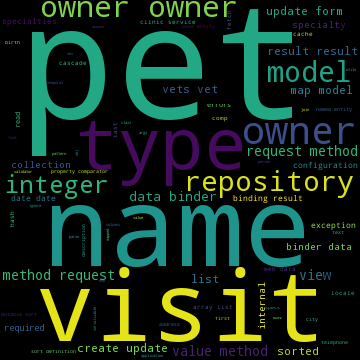

In [11]:
names_text = " ".join(names)
WordCloud(width=360, height=360).generate(names_text).to_image()

Well, I guess the PetClinic software is about "pets" ;-)

# PowerPoint Presentation
Last but not least, to our original goal: creating a word cloud for my PowerPoint presentation (in German and English). 

We use <tt>python-pptx</tt> to wind our way through the presentation.

In [12]:
from pptx import Presentation
PPTX = r'data/talk.pptx'
prs = Presentation(PPTX)

text_fragments = []
for slide in prs.slides:
    
    # store title for later replacement
    title = ""
    if slide.shapes.title and slide.shapes.title.text:
        title = slide.shapes.title.text
     
    # read the slide's notes
    if slide.has_notes_slide:
        notes = slide.notes_slide.notes_text_frame.text
        note_tokens = notes.split(" ")
        text_fragments.extend(s for s in note_tokens if s.isalpha())
    
    # read the slide's text
    for shape in slide.shapes:
        if not shape.has_text_frame:
            continue
        
        text_frame_text = shape.text_frame.text.replace(title, "")
        text_frame_tokens = text_frame_text.split(" ")
        text_fragments.extend(s for s in text_frame_tokens if s.isalpha())
        
text_fragments[:5]

['Nachvollziehbare', 'Analysen', 'in', 'der', 'Harrer']

Cleaning up the tokens is a little bit tricky because we have German as well as English words in it. We also need some additional stop words for words that aren't common but don't make sense in a word cloud.

And we filter out the words that are contained in the stop list.

In [13]:
german_stopword_tokens = stopwords.words('german')
stop_word_tokens = set(german_stopword_tokens) | set(english_stopword_tokens)
custom_stop_words = ["Nichts", "unserer", "viele", "großen", "Du", "Deiner"]
stop_word_tokens = stop_word_tokens | set(custom_stop_words)

text_tokens = [token for token 
               in text_fragments 
               if token not in stop_word_tokens]
text_tokens[:5]

['Nachvollziehbare',
 'Analysen',
 'Harrer',
 'Lösungsoptionen',
 'Softwareentwicklung']

And now finally: The word cloud of my PowerPoint presentation! :-)

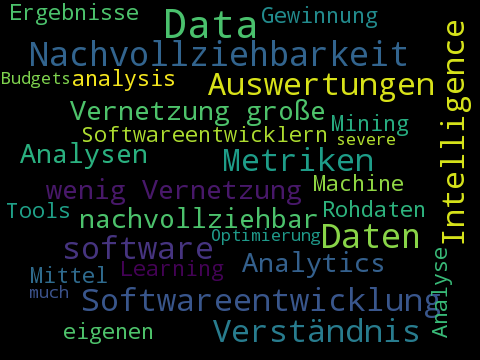

In [14]:
text = " ".join(text_tokens)
WordCloud(min_font_size=30, 
          max_font_size=80, 
          scale=0.5, 
          width=960, 
          height=720).generate(text).to_image()

Nice! For non-German-speakers: It's about reproducible, data-driven, automated software analysis.

# Summary
If you read this, you withstand this long article! I showed you how to extract texts from various formats. As you probably saw, the main work is cleaning up the texts before displaying it properly. It's said that in Data Science, 80% of the analytic's work is cleaning up the data. Well, we certainly saw that today!

Nonetheless, have fun creating your own word clouds!